In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os

MODEL_PATH = 'mi_modelo_mnist.pth'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
else:
    for epoch in range(5):
        running_loss = 0.0
        model.train()
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
    torch.save(model.state_dict(), MODEL_PATH)

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy en test: {100 * correct / total:.2f}%")

Accuracy en test: 99.25%


Imagen original es el número: 6


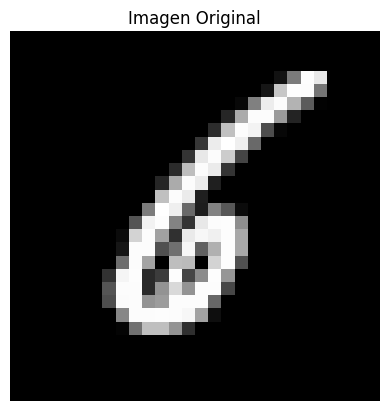

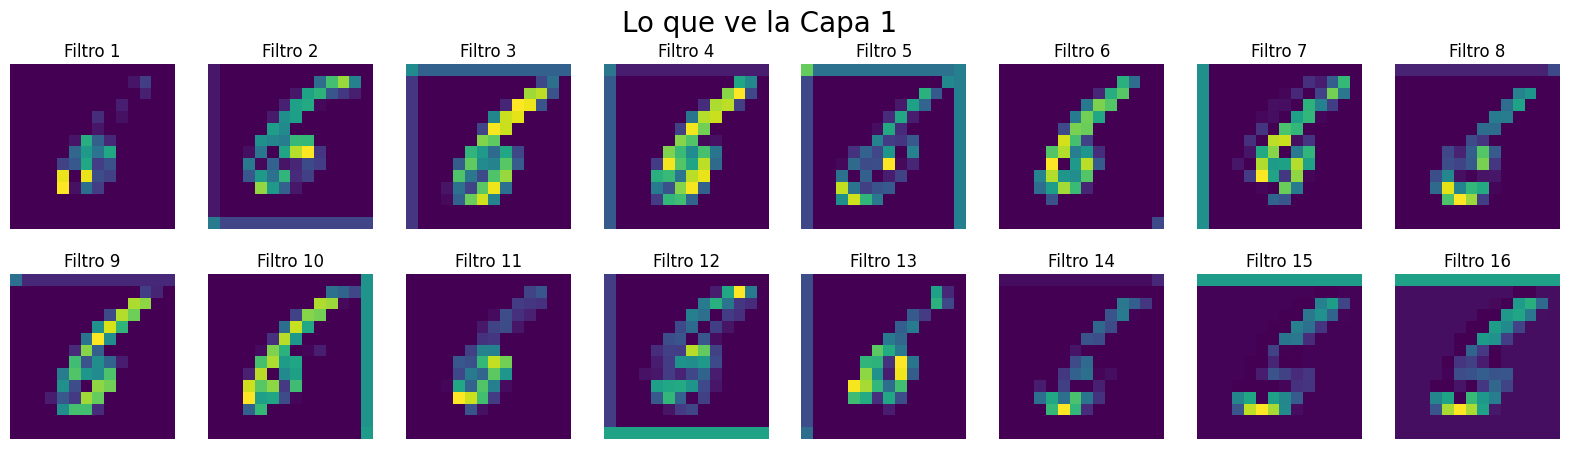

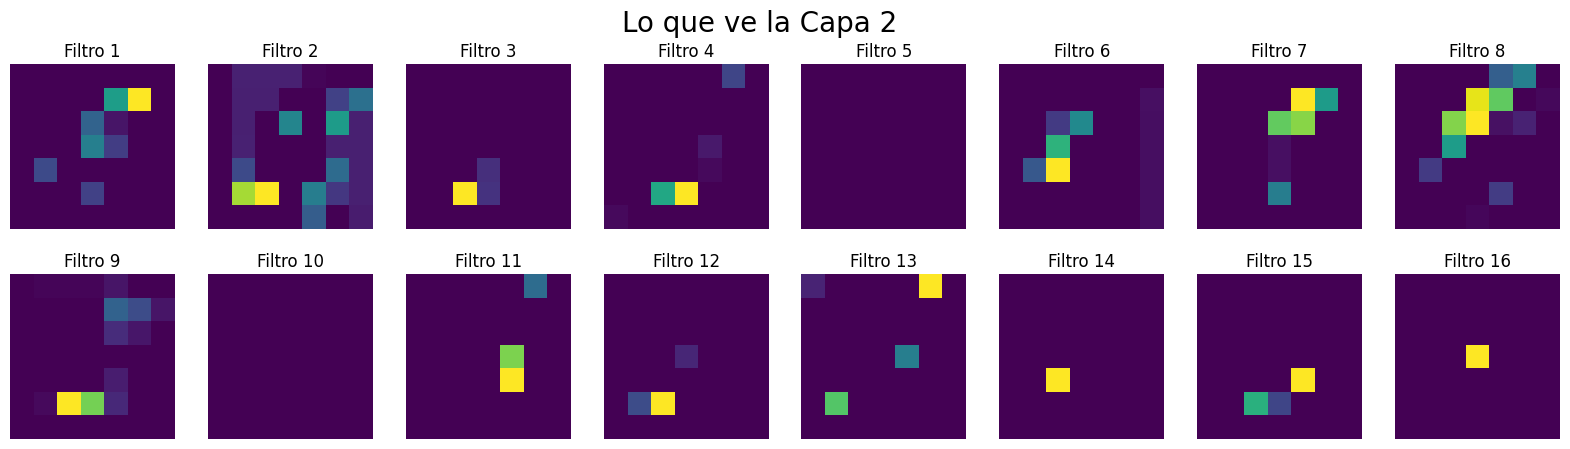

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random

dataiter = iter(testloader)
images, labels = next(dataiter)
index = random.randint(0, 1000)
image = images[index]
img = image.unsqueeze(0)

salida_capa1 = model.pool(model.relu(model.conv1(img)))
salida_capa2 = model.pool(model.relu(model.conv2(salida_capa1)))

def visualizar_filtros(tensor, titulo):
    mapas = tensor.detach().numpy()[0]
    num_filtros = mapas.shape[0]
    filtros_a_mostrar = min(num_filtros, 16)

    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(titulo, fontsize=20)

    for i in range(filtros_a_mostrar):
        ax = fig.add_subplot(2, 8, i+1)
        ax.imshow(mapas[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Filtro {i+1}")
    plt.show()

print(f"Imagen original es el número: {labels[index].item()}")
plt.imshow(images[index].squeeze(), cmap='gray')
plt.title("Imagen Original")
plt.axis('off')
plt.show()

visualizar_filtros(salida_capa1, "Lo que ve la Capa 1")
visualizar_filtros(salida_capa2, "Lo que ve la Capa 2")